In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv
from src.agents.agent import TransformerAgent
from src.envs.trees import TreeEnvVec


# Load Model

In [ ]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")

epoch=9-val_loss=0.833642.ckpt


In [5]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "train_on_last_pred_only": False,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
    "linear_attention": False,
}

In [6]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_343574/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [14]:
is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
n_eval_envs = len(eval_trajs)

In [23]:
i_eval = 4
traj = eval_trajs[i_eval]
env_config = {
    'maze_dim': maze_dim,
    'horizon': 200,
    'state_dim': state_dim,
    'node_encoding_corr': node_encoding_corr,
    'initialization_seed': np.array(traj['initialization_seed']).item(),
    'goal': np.array(traj['goal']),
    'offline_eval_episodes': 1,
    'env': 'darkroom'
}
env = DarkroomEnv(**env_config)
env.reset()


# Helper Functions

In [9]:
def convert_to_path(traj):
    """ Converts a trajectory to a path. """
    path = []
    for observation in traj:
        if not isinstance(observation, list):
            observation = observation.tolist()
        node = env.node_map[tuple(observation)]
        path.append((node.layer, node.pos))
    return path

In [19]:
from src.envs.darkroom import DarkroomEnvVec

def offline(traj, model, config, env):
    """ Runs each episode separately with offline context. """

    n_eval_episodes = config['offline_eval_episodes']
    batch = {
        'context_states': convert_to_tensor([traj['context_states']]),
        'context_actions': convert_to_tensor([traj['context_actions']]),
        'context_next_states': convert_to_tensor([traj['context_next_states']]),
        'context_rewards': convert_to_tensor([traj['context_rewards'][:, None]]),
        }

    # Load agents
    epsgreedy_agent = TransformerAgent(model, batch_size=1, sample=True)
    epsgreedy_agent_2 = TransformerAgent(model, batch_size=1, temp=1, sample=True)
    greedy_agent = TransformerAgent(model, batch_size=1, sample=False)
    epsgreedy_agent.set_batch(batch)
    epsgreedy_agent_2.set_batch(batch)
    greedy_agent.set_batch(batch)

    # Get unique states from context
    seen_states = np.vstack((traj['context_states'][:1], traj['context_next_states']))
    unique_states = np.unique(seen_states, axis=0)  # Get unique states
    possible_eval_states = []
    for state in unique_states:
        state_tuple = tuple(state.tolist())
        if 'darkroom' in config['env']:
            dist_threshold = 2
        elif 'tree' in config['env']:
            dist_threshold = env.max_layers-1
        else:
            raise ValueError(f"Environment {config['env']} not supported.")
        if env.dist_from_goal[state_tuple] >= dist_threshold:
            possible_eval_states.append(state_tuple)
    if len(possible_eval_states) == 0:
        baselines = {
            'Learner (temp=2)': 0,
            'Learner (temp=1)': 0,
            'Learner (greedy)': 0,
        }
        return baselines, None

    # Deploy agents offline
    env.reset_state_bank = possible_eval_states
    if isinstance(env, DarkroomEnv):
        vec_env = DarkroomEnvVec([env])
    else:
        vec_env = TreeEnvVec([env])
    greedy_returns = []
    epsgreedy_returns = []
    epsgreedy_returns_2 = []
    opt_epsgreedy_returns = []
    opt_epsgreedy_returns_2 = []
    opt_greedy_returns = []

    for _ in range(n_eval_episodes):
        _epsgreedy_obs, _, _, _epsgreedy_returns, _opt_returns_epsgreedy = \
            vec_env.deploy_eval(epsgreedy_agent, return_max_rewards=True)
        _epsgreedy_obs_2, _, _, _epsgreedy_returns_2, _opt_returns_epsgreedy_2 = \
            vec_env.deploy_eval(epsgreedy_agent_2, return_max_rewards=True)
        _greedy_obs, _, _, _greedy_returns, _opt_returns_greedy = \
            vec_env.deploy_eval(greedy_agent, return_max_rewards=True)
        epsgreedy_returns.append(np.sum(_epsgreedy_returns))
        epsgreedy_returns_2.append(np.sum(_epsgreedy_returns_2))
        greedy_returns.append(np.sum(_greedy_returns))
        opt_epsgreedy_returns.append(_opt_returns_epsgreedy[0])
        opt_epsgreedy_returns_2.append(_opt_returns_epsgreedy_2[0])
        opt_greedy_returns.append(_opt_returns_greedy[0])

    epsgreedy_returns = np.mean(np.array(epsgreedy_returns)/np.array(opt_epsgreedy_returns))
    epsgreedy_returns_2 = np.mean(np.array(epsgreedy_returns_2)/np.array(opt_epsgreedy_returns_2))
    greedy_returns = np.mean(np.array(greedy_returns)/np.array(opt_greedy_returns))

    print(f"Epsgreedy returns: {epsgreedy_returns}")
    print(f"Greedy returns: {greedy_returns}")
    print()

    # Plot and return
    baselines = {
        'Learner (temp=2)': epsgreedy_returns,
        'Learner (temp=1)': epsgreedy_returns_2,
        'Learner (greedy)': greedy_returns,
    }

    return baselines, _epsgreedy_obs

In [81]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import viridis

def plot_trajectory(G, trajectory):
    """
    Plot a trajectory through a networkx graph with color-coded transitions.
    
    Parameters:
    - G: networkx graph
    - trajectory: list of node IDs representing the path
    - pos: optional dictionary of node positions
    """
    
    pos = {node: node for node in G.nodes()}
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(5, 4))
    
    # Draw the full graph in light gray
    nx.draw_networkx_nodes(G, pos, node_color='lightgray', node_size=100)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', alpha=0.1)
    
    # Create color map for the transitions
    n_transitions = len(trajectory) - 1
    norm = Normalize(vmin=0, vmax=n_transitions)
    
    # Draw each transition with a color based on its timestep
    for i in range(n_transitions):
        start_node = trajectory[i]
        end_node = trajectory[i+1]
        
        # Draw the nodes for this transition
        nx.draw_networkx_nodes(G, pos, 
                             nodelist=[start_node, end_node],
                             node_color='white',
                             node_size=100,
                             edgecolors='black')
        
        # Draw the edge for this transition
        edge_color = viridis(norm(i))
        nx.draw_networkx_edges(G, pos,
                             edgelist=[(start_node, end_node)],
                             edge_color=[edge_color], alpha=0.8,
                             width=4)

    if isinstance(env, DarkroomEnv):
        goal_state = env.node_map_encoding_to_pos[tuple(env.goal.tolist())] 
    else:
        goal_node = env.node_map[tuple(env.goal.tolist())]
        goal_state = (goal_node.layer, goal_node.pos)

    nx.draw_networkx_nodes(G, pos,
                      nodelist=[goal_state],
                      node_color='green',
                      node_size=100,
                      node_shape='*')
    
    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=viridis, norm=norm)
    plt.colorbar(sm, ax=ax, label='Timestep')
    
    plt.title('Trajectory through Graph')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Model Policy Trajectory, Epsilon-Greedy

Epsgreedy returns: 0.0
Greedy returns: 0.0



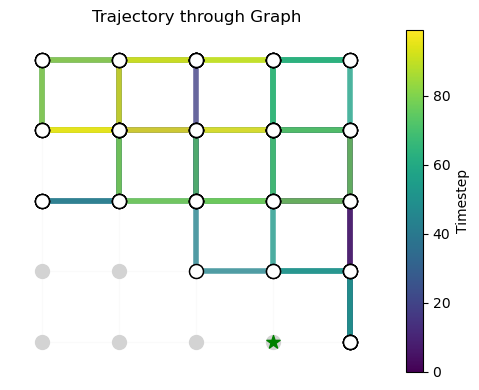

Epsgreedy returns: 1.0
Greedy returns: 1.0



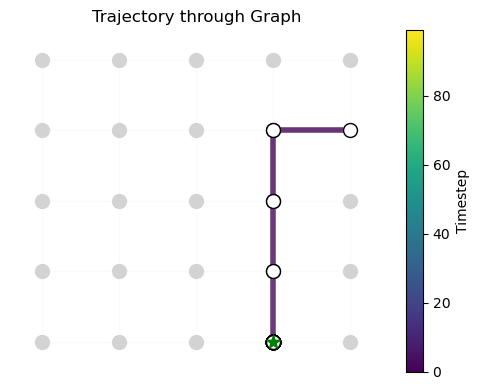

In [88]:
env.horizon = 100
for context_length in [1, 200]:
    _traj = {}
    for k in traj.keys():
        if 'context' in k:
            val = traj[k][:context_length]
        else:
            val = traj[k]
        _traj[k] = val
    
    _, all_obs = offline(_traj, model, env_config, env)
    path = []
    for observation in all_obs[0]:
        if not isinstance(observation, list):
            observation = observation.tolist()
        if isinstance(env, DarkroomEnv):
            node = env.node_map_encoding_to_pos[tuple(observation)]
            path.append(node)
        else:
            node = env.node_map[tuple(observation)]
            path.append((node.layer, node.pos))
    
    plot_trajectory(env.to_networkx(), path)
